In [1]:
#%xmode Verbose

In [2]:
import sys
sys.path.append("../libs/")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from utils import shift_join_data, mae,rmse,mape,print_line, plot_pred, plot_history
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import datetime
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
# Ruta del modelo con hiperparametros optimizados (sin entrenar)
model_path = 'resultados/CNN_20220731_1050_1.h5'
# Callback para detener el entrenamiento cuando el error de validacion no disminuye despues de 50 epocas
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)
mini_batch = 32
n_epochs= 2000  # Nro de epocas maximas
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
res_name = 'resultados/CNN_TR_'+fecha_hora
n_iter = 30
learning_rate = 1e-3

# Carga de datos

In [5]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

Paises

In [6]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [8]:
iso_train = ['PER']
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

Países de Entrenamiento

In [9]:
print(iso_train)

['PER']


Features de Entrenamiento

In [10]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


# Normalizar

In [11]:
df_x = df.loc[iso_train][features].copy()
df_y = df.loc[iso_train][target_col].copy()

std_scaler_x = StandardScaler()
std_scaler_y = StandardScaler()

df_x.iloc[:,:] = std_scaler_x.fit_transform(df_x)
df_y.iloc[:,:] = std_scaler_y.fit_transform(df_y)

df_x.iloc[:,:] = np.clip(df_x,-3,3)
df_y.iloc[:,:] = np.clip(df_y,-3,3)

# Generar variables lag y horizonte

In [12]:
n_steps_in = 9
n_steps_out = 3
n_features = len(features)

x, y = shift_join_data(df_x,df_y,iso_train,n_steps_in,n_steps_out)

x_train, y_train = x[:int(len(x)*0.7)], y[:int(len(y)*0.7)]
x_test, y_test = x[- int(len(x)*0.3):], y[- int(len(y)*0.3):]


# Entrenamiento y evaluación

In [13]:
def evaluar_cnn_tr_tr(x_train : np.ndarray, y_train : np.ndarray, x_test : np.ndarray,
        y_test : np.ndarray, n_iter : int, scaler : StandardScaler):
    n_splits = 5    # Nro de K Folds para CV
    res_path = res_name+'.csv'
    tscv = TimeSeriesSplit(n_splits = n_splits)
    print_line("mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3\n",res_path)
    # Inicio
    print('Inicio de evaluacion:')
    for i in range(n_iter):
        val_mae = list()
        val_rmse = list()
        val_mape = list()
        for train_idx, test_idx in tscv.split(x_train):
            # CV split
            x_t, y_t = x_train[train_idx], y_train[train_idx]
            x_v, y_v = x_train[test_idx], y_train[test_idx]
            # Entrenamiento
            model = load_model(model_path)
            model.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
            model.fit(x_t, y_t, validation_data = (x_v, y_v), epochs = n_epochs,
                batch_size = mini_batch, callbacks = [es], shuffle = False, verbose = 0)
            # Prediccion
            y_pred = model(x_test)
            # Denormalizando
            dn_y_test = scaler.inverse_transform(y_test)
            dn_y_pred = scaler.inverse_transform(y_pred)
            # Evaluacion
            val_mae.append(mae(dn_y_test, dn_y_pred))
            val_rmse.append(rmse(dn_y_test, dn_y_pred))
            val_mape.append(mape(dn_y_test, dn_y_pred))
        # Promedios
        mean_mae = np.mean(val_mae,axis=0)
        mean_rmse = np.mean(val_rmse,axis=0)
        mean_mape = np.mean(val_mape,axis=0)
        print_line('{},{},{},{},{},{},{},{},{}\n'.format(mean_mae[0],mean_mae[1],mean_mae[2],
            mean_rmse[0],mean_rmse[1],mean_rmse[2],mean_mape[0],mean_mape[1],mean_mape[2]),res_path)
        print('Iter: {}/{} completado.'.format(i+1,n_iter))
    print('Fin de evaluacion.')

In [14]:
# evaluar
evaluar_cnn_tr_tr(x_train, y_train, x_test, y_test,n_iter,std_scaler_y)

Inicio de evaluacion:
Iter: 1/30 completado.
Iter: 2/30 completado.
Iter: 3/30 completado.
Iter: 4/30 completado.
Iter: 5/30 completado.
Iter: 6/30 completado.
Iter: 7/30 completado.
Iter: 8/30 completado.
Iter: 9/30 completado.
Iter: 10/30 completado.
Iter: 11/30 completado.
Iter: 12/30 completado.
Iter: 13/30 completado.
Iter: 14/30 completado.
Iter: 15/30 completado.
Iter: 16/30 completado.
Iter: 17/30 completado.
Iter: 18/30 completado.
Iter: 19/30 completado.
Iter: 20/30 completado.
Iter: 21/30 completado.
Iter: 22/30 completado.
Iter: 23/30 completado.
Iter: 24/30 completado.
Iter: 25/30 completado.
Iter: 26/30 completado.
Iter: 27/30 completado.
Iter: 28/30 completado.
Iter: 29/30 completado.
Iter: 30/30 completado.
Fin de evaluacion.


# Resultados

In [15]:
df_res = pd.read_csv(res_name+'.csv')

In [16]:
df_res.describe()

,mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.679783,1.403950,2.258395,2.164901,1.854781,3.044833,45.708707,34.200329,43.893617
std,0.130090,0.117937,0.119608,0.128778,0.118436,0.155725,3.537350,3.783990,2.727143
min,1.470617,1.222635,2.037472,2.005637,1.687317,2.782412,38.677890,28.247913,39.077466
25%,1.600059,1.330859,2.165632,2.068056,1.782108,2.933730,43.766787,31.657025,41.770878
50%,1.643907,1.373552,2.246055,2.128013,1.822448,3.026977,44.428464,33.348843,43.361622
75%,1.743708,1.448933,2.330421,2.223532,1.918903,3.111483,47.790968,36.098182,46.159692
max,1.980621,1.714337,2.569923,2.509819,2.167575,3.462835,54.355412,41.652551,50.548307


<AxesSubplot:>

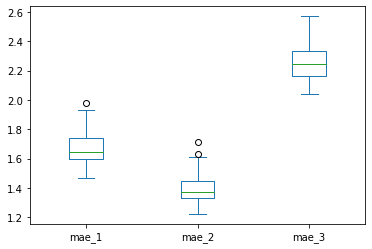

In [17]:
df_res[['mae_1','mae_2','mae_3']].plot.box()

<AxesSubplot:>

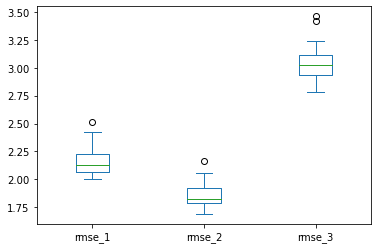

In [18]:
df_res[['rmse_1','rmse_2','rmse_3']].plot.box()

<AxesSubplot:>

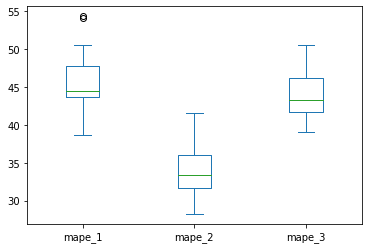

In [19]:
df_res[['mape_1','mape_2','mape_3']].plot.box()

# Prediccion

In [20]:
def predecir():
    models = list()
    rmse_vals = list()
    for i in range(n_iter):
        model = load_model(model_path)
        model.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
        model.fit(x_train, y_train, validation_split = 0.3, epochs = n_epochs,
                    batch_size = mini_batch, callbacks = [es], shuffle = False, verbose = 0)
        y_pred = model(x_test)
        dn_y_test = std_scaler_y.inverse_transform(y_test)
        dn_y_pred = std_scaler_y.inverse_transform(y_pred)
        rmse_vals.append(rmse(dn_y_test, dn_y_pred)[0])
        model.save(res_name+'_'+str(i)+'.h5')
    print('Mejor valor: {}, iter: {}'.format(np.min(rmse_vals), np.argmin(rmse_vals)))
    return np.argmin(rmse_vals)

In [21]:
best_iter = predecir()

Mejor valor: 1.8528504704452269, iter: 29


(3, 12)


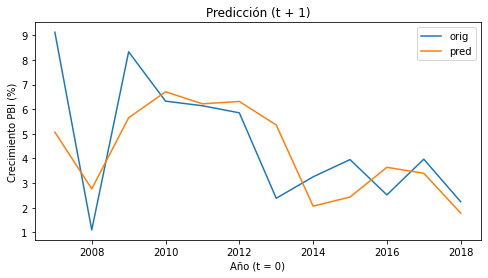

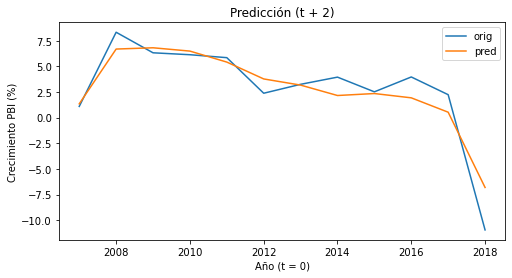

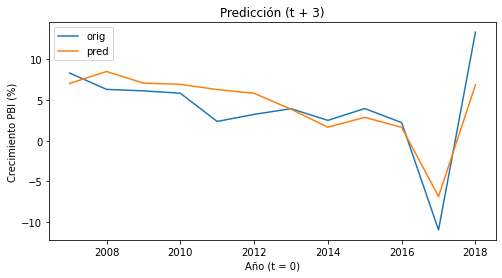

In [22]:

model = load_model(res_name+'_'+str(best_iter)+'.h5')
y_pred = model(x_test)
dn_y_test = std_scaler_y.inverse_transform(y_test)
dn_y_pred = std_scaler_y.inverse_transform(y_pred)
plot_pred(dn_y_test, dn_y_pred,2021)

In [23]:
from notifications import enviar_correo
enviar_correo("Evaluacion Finalizado!","Se ha completado: {}".format(res_name))